## Imports & constants

In [1]:
import os
from copy import copy
from itertools import chain
from collections import defaultdict
from functools import partial
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats

# plotting and visuals
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scikitplot as skplt
import logomaker
from tqdm import tqdm
from IPython.display import display
theme_bw = 'theme_bw.mplstyle'   # mimic theme_bw from ggplot2
plt.style.use(theme_bw)

# preprocessing and model selection
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
import umap

# Machine Learning models
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# label for data provided by supervisor
OUR = 'Shomuradova et al.'  
# label for data from "Use of machine learning to identify a 
# T cell response to SARS-CoV-2" article
PAPER = 'Shoukat et al.'    
# p-value for statistical tests
ALPHA = 0.05  

# 0 Generating frequency tables
This section deals with the generation of `.csv` files which contain frequency of 3-mers, as well as V-, D-, and J-segments for each sample, with and without normalization for comparison. The resulting files (`freq_table.csv` and `freq_table_normalized.csv`) can be found in the repository.

#### Dataframes from tables for format inspection 

In [3]:
# load records from both datasets for format inspection
our_test_df = pd.read_csv('convalescent/down.1434.TRB.txt', sep='\t')
paper_test_df = pd.read_csv('use_of_ml_paper_data/patient/Pt-11-1.clonotypes.TRB.txt.gz', sep='\t')

In [72]:
def rename_table_fields(df):
    """
    Rename columns in DataFrame so they match with Shomuradova et al. format 
    (in folders ./healthy and ./convalescent)
    
    df should be DataFrame constructed from MiXCR output table.
    """
    cols = ['allVHitsWithScore', 'allDHitsWithScore', 'allJHitsWithScore']
    for col in cols:
        df[col[3].lower()] = df[col].apply(lambda x: \
                                         x.split(',')[0].split('*')[0] if pd.notna(x) else x) 
    df.drop(columns=cols)
    df['freq'] = df['cloneFraction']
    df['count'] = df['cloneCount']
    df['cdr3aa'] = df['aaSeqCDR3']
    return df
    
    
def normalize_v_usage(df):
    """
    Perform v-usage normalization in two steps:
    
    1. For each unique V segment make sum of clonotype frequencies 
    with this segment equal to 1
    2. Normalize frequencies so that sum of all frequencies in sample is equal to 1
    """
    unique_vgenes = np.unique(df['v'])
    for uq_vgene in unique_vgenes:
        total_freq = df.query('v == @uq_vgene')['freq'].sum()
        df['freq'] = np.where(df['v'] == uq_vgene, df['freq'] / total_freq, df['freq'])
    df['freq'] = df['freq'] / df['freq'].sum()
    return df
        
        
def find_kmers(seq, k):
    """
    Generate k-mers given string seq
    """
    for i in range(0, len(seq) - k + 1):
        yield i, seq[i:i+k]

def count_segments(df):
    """
    Returns two-level dictionary; first key is either v, d or j;
    
    Inner dictionary contains frequencies for each unique segment.
    """
    results = {letter: defaultdict(int) for letter in 'vdj'}
    cumulative_fraction = 0
    for i, clone in df.iterrows():
        for letter in 'vdj':
            segment_id = clone[letter]
            if pd.notna(segment_id) and segment_id != '.':
                results[letter][segment_id] += clone['freq']
        cumulative_fraction += clone['freq']
    return results

def count_kmers(df, k=3, most_common=300):
    """
    Returns dictionary with frequencies of most common k-mers
    """
    tmp = defaultdict(int)
    for i, clone in df.iterrows():
        seq = clone['cdr3aa'].replace('_', '').replace('*', '')
        for _, kmer in find_kmers(seq, k):
            tmp[kmer] += clone['freq']
    results = defaultdict(int)     
    results.update(dict(sorted(tmp.items(), key=lambda x: -x[1])[:most_common]))
    return results

def read_folder(folder, source, group, k=3, most_common_kmers=300, v_gene_normalize=False):
    """
    Process all records in given foler
    
    Returns DataFrame with rows corresponding to individual records 
    containing frequency for all kmers, as well as V-, D-, and J-segments.
    
    Can optionally perform V usage normalization.
    """
    if not folder.endswith('/'):
        folder += '/'
    list_of_records = []
    for i, filename in tqdm(enumerate(os.listdir(folder))):
        
        df = pd.read_csv(folder + filename, sep='\t')
        
        if source == 'paper':
            df = rename_table_fields(df)
            
        if v_gene_normalize:
            df = normalize_v_usage(df)
            
        df = df[['count', 'freq', 'cdr3aa', 'v', 'd', 'j']]
        
        segments = count_segments(df)
        record = count_kmers(df, k=k, most_common=most_common_kmers,)
        
        for segment_letter, segment_id_counts in segments.items():
            record.update(segment_id_counts)
        
        record['id'] = source[0] + group[0] + str(i)
        record['source_short'] = source
        record['source'] = 'Shomuradova et al.' if source == 'our' else 'Shoukat et al.'
        if group == 'Healthy':
            record['label'] = 0
        else:
            record['label'] = 1
        
        list_of_records.append(record)
        
    df = pd.DataFrame(list_of_records)
    df.set_index('id', inplace=True)
    return df

The next cell is performed twice with `normalize_flag` changed to `True` a second time, and commeting toggled in the last two lines. Files `freq_table.csv` and `freq_table_normalized.csv` can be found in repository.

In [189]:
normalize_flag = True
k = 3

our_healthy = read_folder('healthy/', 'our', 'Healthy', k=k, 
                         v_gene_normalize=normalize_flag)
our_patients = read_folder('convalescent/', 'our', 'Patient', k=k, 
                        v_gene_normalize=normalize_flag)
paper_patients = read_folder('use_of_ml_paper_data/patient/', 'paper', 'Patient', k=k, 
                           v_gene_normalize=normalize_flag)
paper_healthy = read_folder('use_of_ml_paper_data/healthy/', 'paper', 'Healthy', k=k, 
                           v_gene_normalize=normalize_flag)

all_data = pd.concat([our_healthy, our_patients, paper_healthy, paper_patients])
all_data.fillna(0, inplace=True)

all_data.to_csv('freq_table.csv')
# all_data.to_csv('freq_table_normalized.csv')

14it [02:27, 10.52s/it]
20it [04:11, 12.57s/it]
6it [00:30,  4.66s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
9it [00:46,  4.91s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
19it [01:31,  4.81s/it]
38it [01:22,  2.16s/it]


#### Read not normalized data

# 1 Loading frequency tables and selecting subsets

In [6]:
# read not normalized data
all_data = pd.read_csv('freq_table.csv').set_index('id')

In [9]:
# read normalized data
all_data = pd.read_csv('freq_table_normalized.csv').set_index('id')

#### Selecting subsets of the data
The lists from the cell below represent "groups" of predictors and other column names to rapidly select different subsets (e.g. kmers + V-segments; k-mers + J-segments etc.) for performing downstream analysis.

In [3]:
j_segment_labels = [col for col in all_data.columns if col.startswith('TRBJ')]
v_segment_labels = [col for col in all_data.columns if col.startswith('TRBV')]
d_segment_labels = [col for col in all_data.columns if col.startswith('TRBD')]
all_segment_labels = [col for col in all_data.columns if col.startswith('TRB')]

source_labels =['source', 'source_short']

kmer_labels = set(all_data.columns) - set(v_segment_labels) - set(j_segment_labels) - \
    set(d_segment_labels) - set(source_labels) - set(['label'])

In [98]:
df = all_data.copy() 

# uncomment one the lines below to select only certain columns

# df = all_data.drop(columns=all_segment_labels)  # only kmers
# df = all_data.drop(columns=v_segment_labels).copy() # kmers + d + j
# df = all_data.drop(columns=j_segment_labels + d_segment_labels)  # kmer + v
# df = all_data[v_segment_labels+ source_labels + j_segment_labels + ['label']]  # v  + j
# df = all_data[ j_segment_labels + source_labels + ['label']]  # only j
# df = all_data.drop(columns=v_segment_labels + d_segment_labels)
# df = all_data.drop(columns=j_segment_labels + d_segment_labels)

our_data = df.query('source_short == "our"')
paper_data = df.query('source_short == "paper"')

X = df.drop(columns=['source', 'label', 'source_short']).to_numpy()
y = df['label'].to_numpy()

our_X = our_data.drop(columns=['source', 'label', 'source_short']).to_numpy()
our_y = our_data['label'].to_numpy()

paper_X = paper_data.drop(columns=['source', 'label', 'source_short']).to_numpy()
paper_y = paper_data['label'].to_numpy()

sc = StandardScaler() # different scalers were tried out; StandardScaler works best
# sc = RobustScaler()
# sc = MinMaxScaler()

X_scaled = sc.fit_transform(X)
our_X_scaled = sc.fit_transform(our_X)
paper_X_scaled = sc.fit_transform(paper_X)

## Data visualization
Perform visualization to compare datasets before/after normalization and see if the data possesses any structure.

### PCA

#### Explained variance

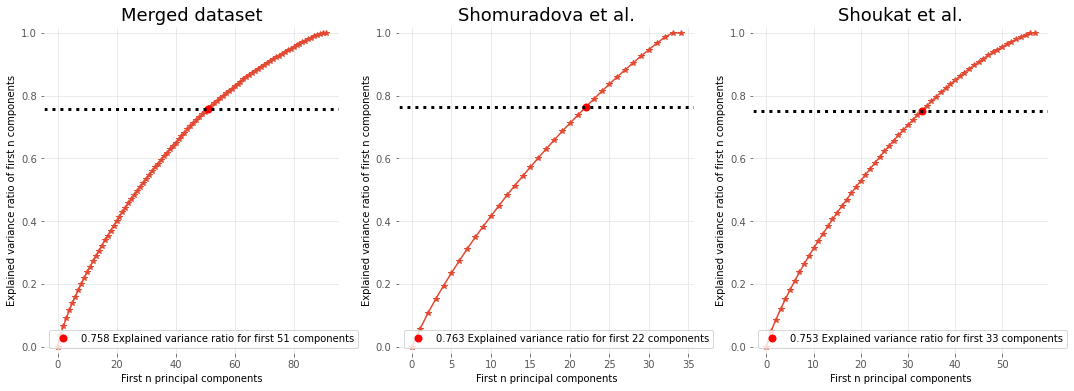

In [125]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

pca = PCA()

for dataset, title, ax in zip([X_scaled, our_X_scaled, paper_X_scaled], ['Merged dataset', OUR, PAPER], axs):
    pca.fit(dataset)
    skplt.decomposition.plot_pca_component_variance(pca, ax=ax)
    ax.set_title(title, fontsize=18)
    
plt.savefig('explained_variance_kmer_only.png')

Large difference between datasets can be seen at this point: number of principal components to achieve the same explained variance ratio increases greatly after merging the datasets.

#### Joint Plots

In [115]:
def drop_outliers(X, y, source=None, n_max=1):
    """Removes two eye-balled outliers from the Shomuradova et al. dataset"""
    cols = ['PC1', 'PC2']
    tmp = pd.DataFrame(X, columns=cols)
    tmp['label'] = y
    if source is None:
        pass
    else:
        tmp['source'] = source
    for col in cols:
        max_value = tmp[col].max()
        tmp = tmp[tmp[col] != max_value]
    if source is None:
        return tmp[cols].to_numpy(), tmp['label'] 
    else:
        return tmp[cols].to_numpy(), tmp['label'], tmp['source']

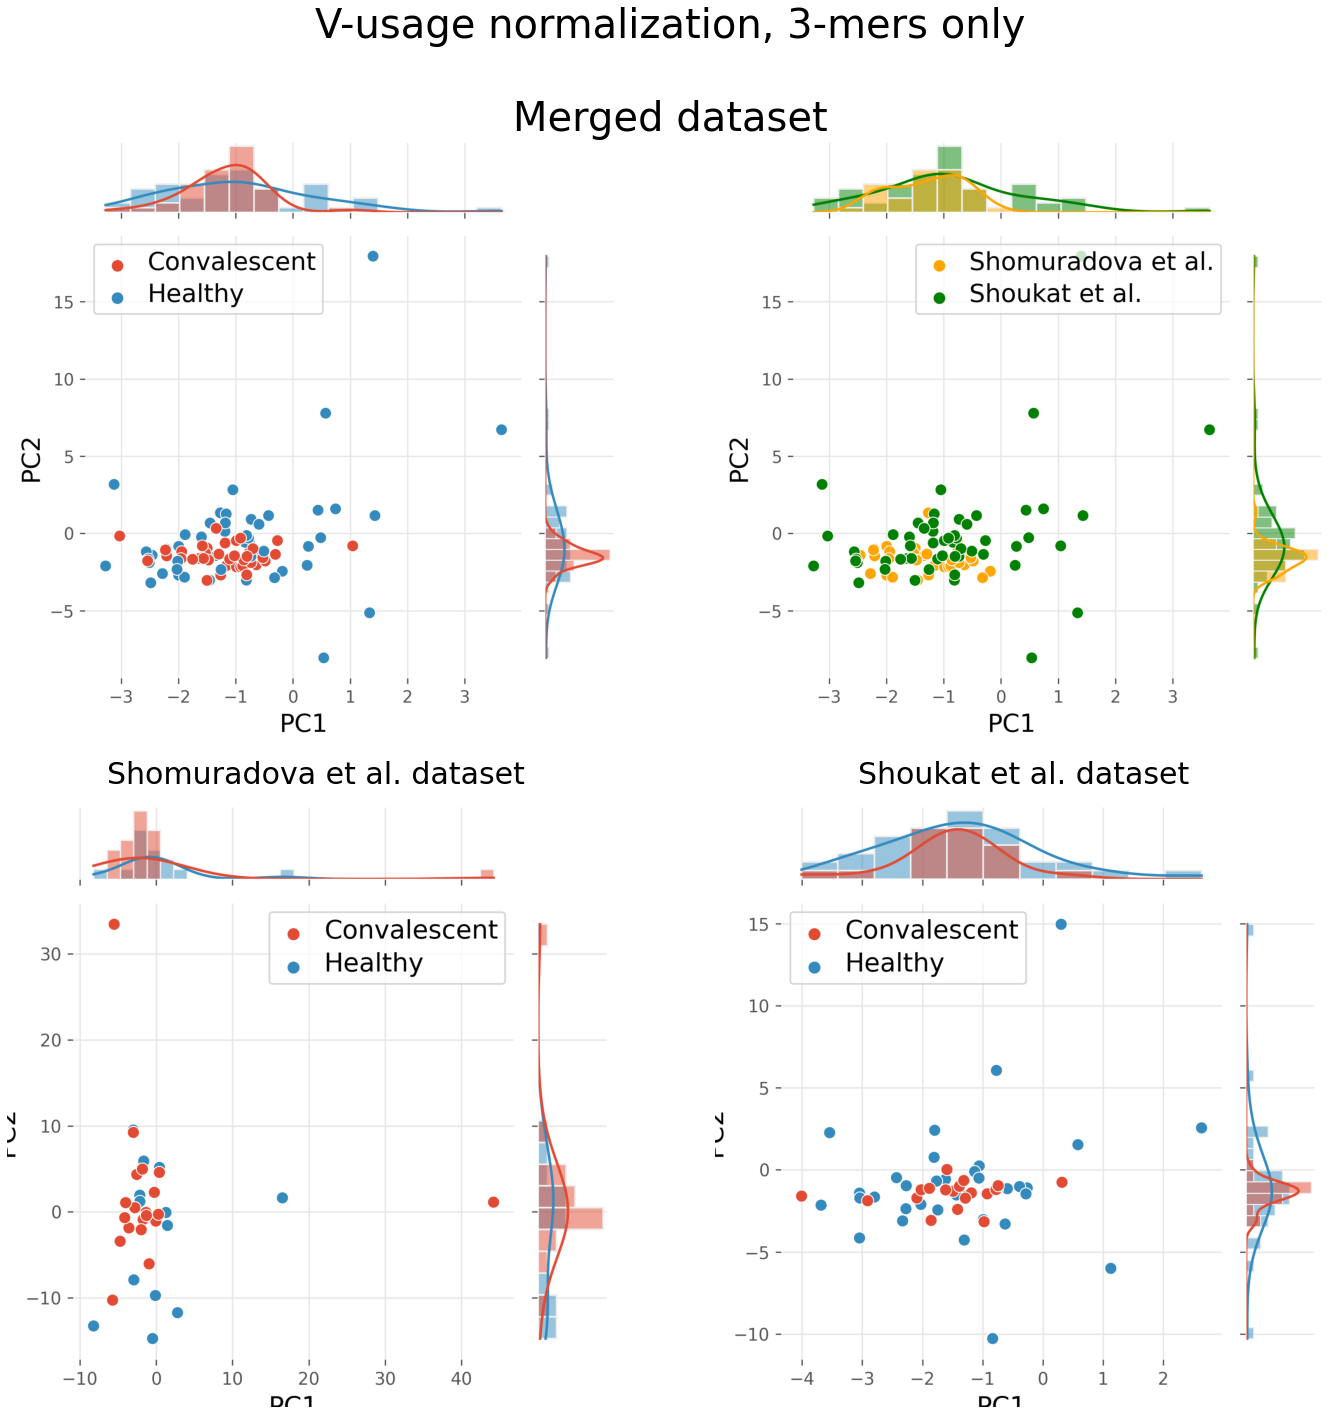

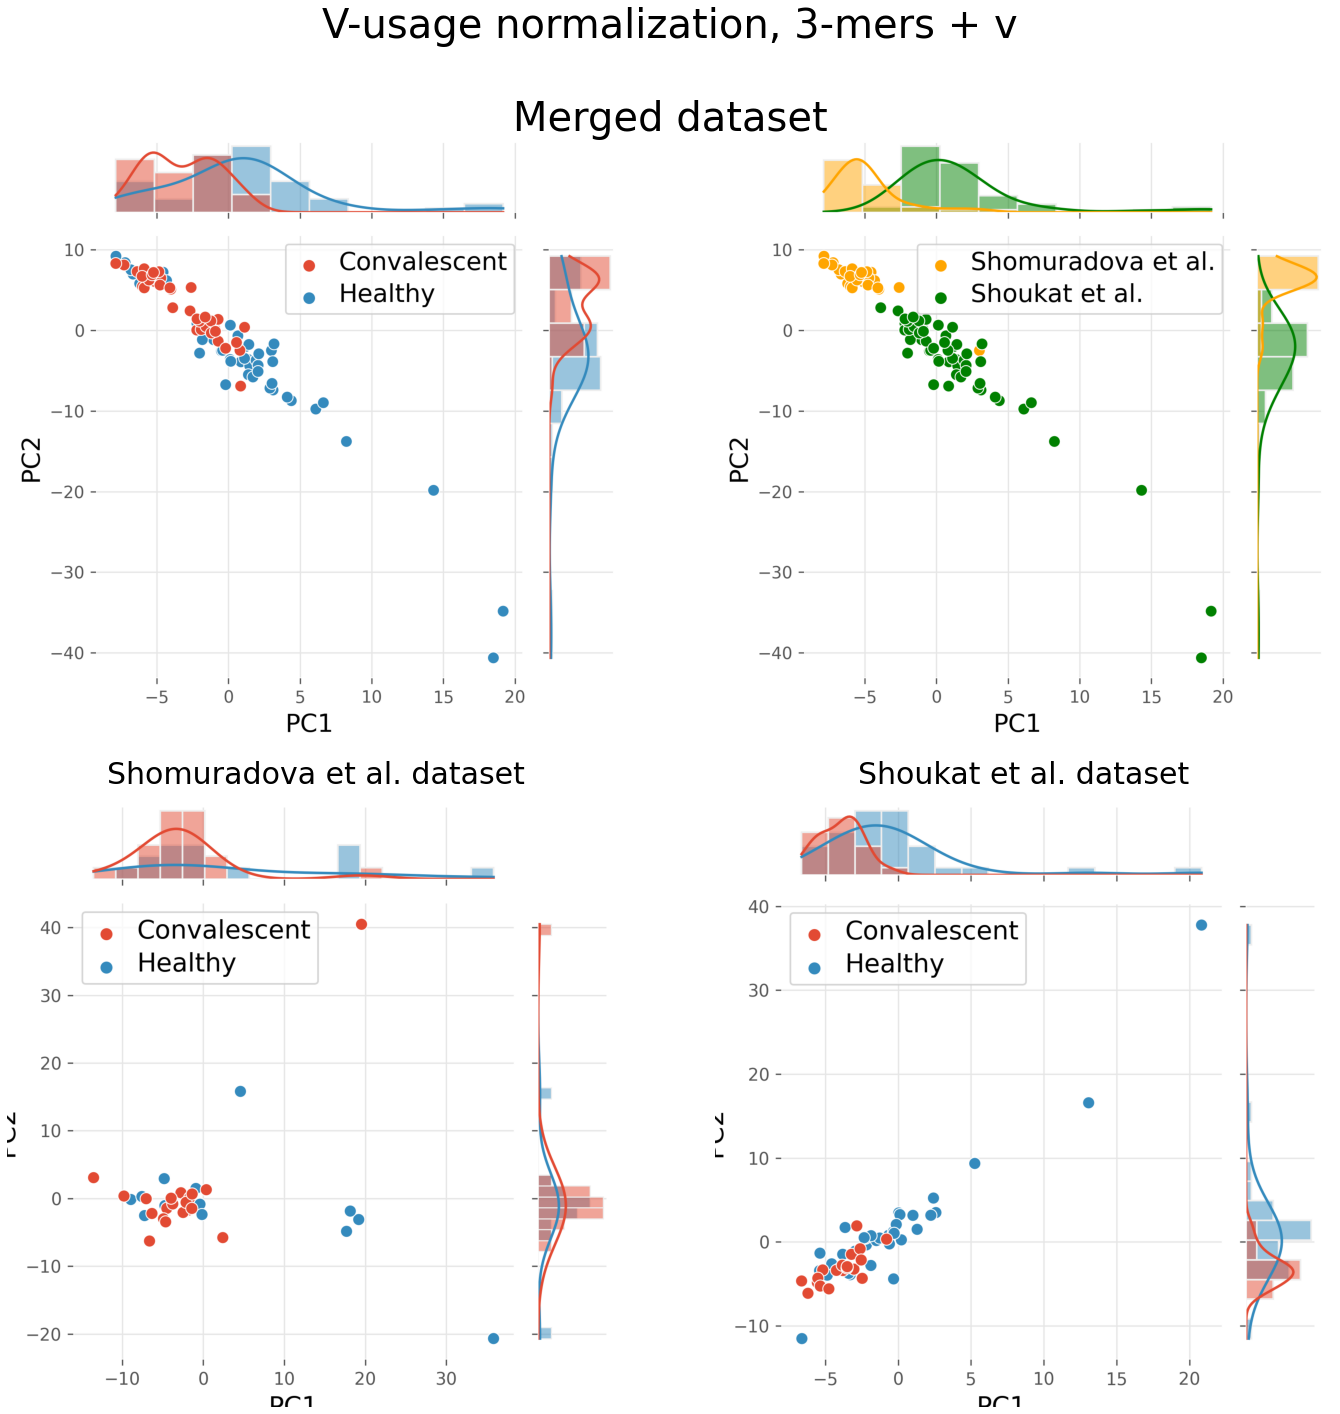

In [122]:
def make_plots(suptitle='', features='3-mers only', dpi=300):
    """
    Creates 4 plots:
    1. Merged dataset; samples colored by label (Convalescent or Healthy)
    2. Merged dataset; samples colored by dataset
    3. Shomuradova et al. dataset; samples colored by label
    4. Shoukat et al. dataset; samples colored by label
    """
    
    if features == '3-mers only':
        X_all = all_data[kmer_labels].to_numpy()
        X_our = our_data[kmer_labels].to_numpy()
        X_paper = paper_data[kmer_labels].to_numpy()
    else:
        X_all = all_data[list(kmer_labels) + v_segment_labels].to_numpy()
        X_our = our_data[list(kmer_labels) + v_segment_labels].to_numpy()
        X_paper = paper_data[list(kmer_labels) + v_segment_labels].to_numpy()
    
    def decode_target_labels(y):
        return np.where(y, 'Convalescent', 'Healthy')
    
    y = decode_target_labels(all_data['label'])
        
    X_all = StandardScaler().fit_transform(X_all)
    X_all = PCA(n_components=2).fit_transform(X_all)
    X_all, y, source = drop_outliers(X_all, y, all_data['source'].to_numpy())
    
    def make_jg(X, hue, hue_order, palette=None):
        jp = sns.JointGrid(x=X[:, 0], y=X[:, 1], hue=hue, height=5, 
                          hue_order=hue_order, palette=palette) 

        jp.plot_joint(sns.scatterplot, s=50, )
        jp.plot_marginals(sns.histplot, kde=True)

        jp.fig.tight_layout()

        jp.ax_joint.set_xlabel("PC1", fontsize=15);
        jp.ax_joint.set_ylabel('PC2', fontsize=15);

        leg = jp.ax_joint.get_legend()
        leg.set_title('')
        for text in leg.texts:
            text.set_fontsize(15)
        return jp
    
    jp1 = make_jg(X_all, hue=y, hue_order=['Convalescent', 'Healthy'])
    jp2 = make_jg(X_all, hue=source, hue_order=[OUR, PAPER], palette=['orange', 'green'])
    plt.close(jp1.fig)
    plt.close(jp2.fig)
    jp1.savefig('jp1.png', dpi=dpi)
    jp2.savefig('jp2.png', dpi=dpi)
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    axs[0, 0].imshow(mpimg.imread('jp1.png'))
    axs[0, 1].imshow(mpimg.imread('jp2.png'))
    
    datasets = [
        (X_our, our_data['label'], OUR),
        (X_paper, paper_data['label'], PAPER)
    ]
    for i, (X, y, dataset_source) in enumerate(datasets):
        y = decode_target_labels(y)
        X = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))
        if dataset_source == PAPER:
            X, y = drop_outliers(X, y)
        jp = make_jg(X, hue=y, hue_order=['Convalescent', 'Healthy'])
        plt.savefig('jp.png', dpi=dpi)
        plt.close(jp.fig)
        axs[1][i].imshow(mpimg.imread('jp.png'))
        axs[1][i].set_title(dataset_source + ' dataset', fontsize=30)
        
    for ax in axs.reshape(-1):
        ax.set_axis_off()
    
    fig.suptitle(f'{suptitle}, {features}\n\nMerged dataset', fontsize=40)
    fig.tight_layout()
    plt.savefig(suptitle + ' ' + features)

suptitle = 'V-usage normalization'
make_plots(suptitle=suptitle)
make_plots(suptitle=suptitle, features='3-mers + v')

### UMAP

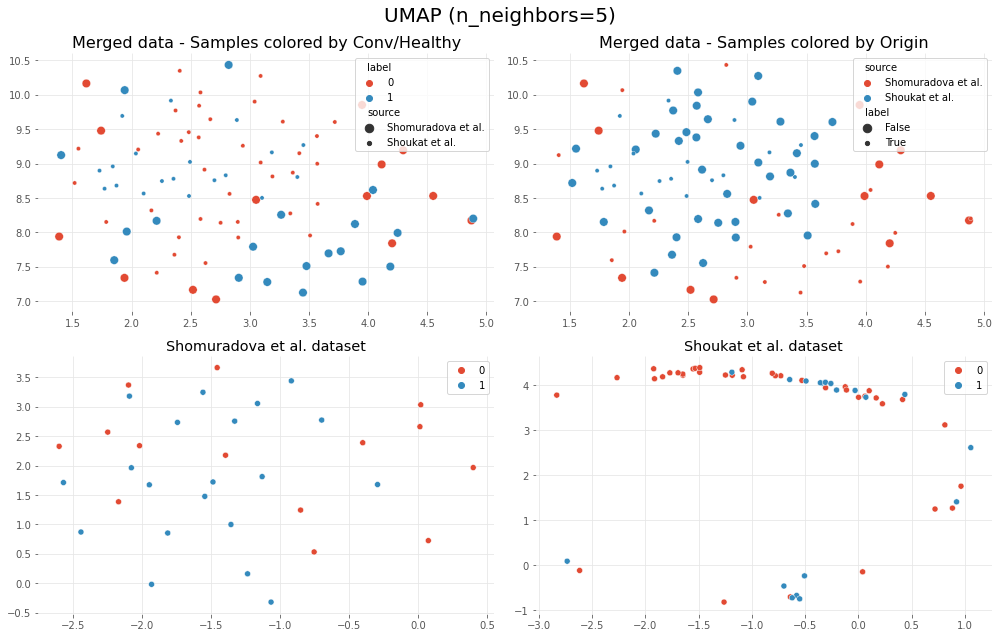

In [128]:
def draw_umap(n, title, scaled=False):
    reducer = umap.UMAP(random_state=28, n_neighbors=n, min_dist=0.0, metric='euclidean')
    
    if scaled:
        sc = StandardScaler()
        X_scaled = sc.fit_transform(X)
        our_X_scaled = sc.fit_transform(our_X)
        paper_X_scaled = sc.fit_transform(paper_X)
        
        X_mapped = reducer.fit_transform(X_scaled)
        our_X_mapped = reducer.fit_transform(our_X_scaled)
        paper_X_mapped = reducer.transform(paper_X_scaled)
    else:
        X_mapped = reducer.fit_transform(X)
        our_X_mapped = reducer.fit_transform(our_X)
        paper_X_mapped = reducer.transform(paper_X)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 9))
    sns.scatterplot(x=X_mapped[:, 0], y=X_mapped[:, 1], hue=df['label'], ax=ax[0][0], 
                    size=df['source'])
    ax[0][0].set_title('Merged data - Samples colored by Conv/Healthy', fontsize=16)
    
    sns.scatterplot(x=X_mapped[:, 0], y=X_mapped[:, 1], hue=df['source'], ax=ax[0][1],
                   size=df['label'] == 1)
    ax[0][1].set_title('Merged data - Samples colored by Origin', fontsize=16)
    
    ax1 = ax[1]
    
    sns.scatterplot(x=our_X_mapped[:, 0], y=our_X_mapped[:, 1], hue=pd.Series(our_y), ax=ax1[0])
    ax1[0].set_title('Shomuradova et al. dataset')
    
    sns.scatterplot(x=paper_X_mapped[:, 0], y=paper_X_mapped[:, 1], hue=pd.Series(paper_y), ax=ax1[1])
    ax1[1].set_title('Shoukat et al. dataset')
    
    fig.suptitle(f'UMAP (n_neighbors={n})', fontsize=20)
    fig.tight_layout()
    plt.savefig(str(n) + title +'.png')

draw_umap(5, 'umap_kmer_only', scaled=True)

## ML models

#### CatBoost

Train dataset:	Shomuradova et al.
accuracy:	0.631578947368421
roc-auc:	0.4736842105263158
precision:	0.0
f1-score:	0.0
Train dataset:	Shoukat et al.
accuracy:	0.7647058823529411
roc-auc:	0.7678571428571428
precision:	0.8333333333333334
f1-score:	0.7894736842105262
Train dataset:	Merged (test_size=0.3)
accuracy:	0.5
roc-auc:	0.4769230769230769
precision:	0.4
f1-score:	0.2222222222222222


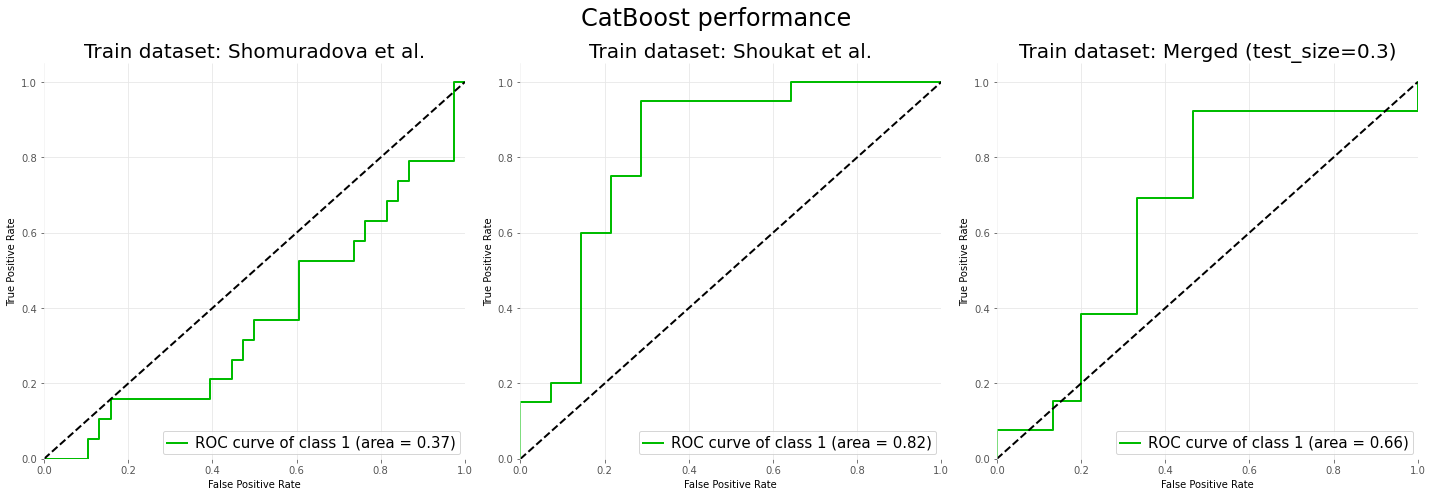

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
models = []
pcas = []
scalers = []

for i, title in zip(range(3), [OUR, PAPER, 'Merged (test_size=0.3)']):
    if i == 0:
        X_train, y_train = our_X, our_y
        X_test, y_test = paper_X, paper_y
    elif i == 1:
        X_train, y_train = paper_X, paper_y
        X_test, y_test = our_X, our_y
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    scalers.append(sc)

    pca = PCA(n_components=min(50, X_train.shape[0]))
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    pcas.append(pca)

    # recommended weights for imbalanced classes
    weights = [1, np.sum(y_train == 0) / np.sum(y_train)]  
    clf = CatBoostClassifier(verbose=False, class_weights=weights)
    clf.fit(X_train, y_train)
    models.append(clf)

    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    print('Train dataset:', title, sep='\t')
    print('accuracy:', accuracy_score(y_test, y_pred), sep='\t')
    print('roc-auc:', roc_auc_score(y_test, y_pred), sep='\t')
    print('precision:', precision_score(y_test, y_pred), sep='\t')
    print('f1-score:', f1_score(y_test, y_pred), sep='\t')
    print('=' * 30)
    skplt.metrics.plot_roc(y_test, y_pred_prob, classes_to_plot=[1], figsize=(8, 6), ax=axs[i],
                          plot_macro=False, plot_micro=False);
    axs[i].set_title('Train dataset: ' + title, fontsize=20)
    for item in axs[i].get_legend().get_texts():
        item.set_fontsize(15)
    
fig.suptitle('CatBoost performance', fontsize=24)
fig.tight_layout();
plt.savefig('catboost_roc_kmer_only')

The model performs poorly when trained on Shomuradova et al. dataset.

#### Hierarchical clustering

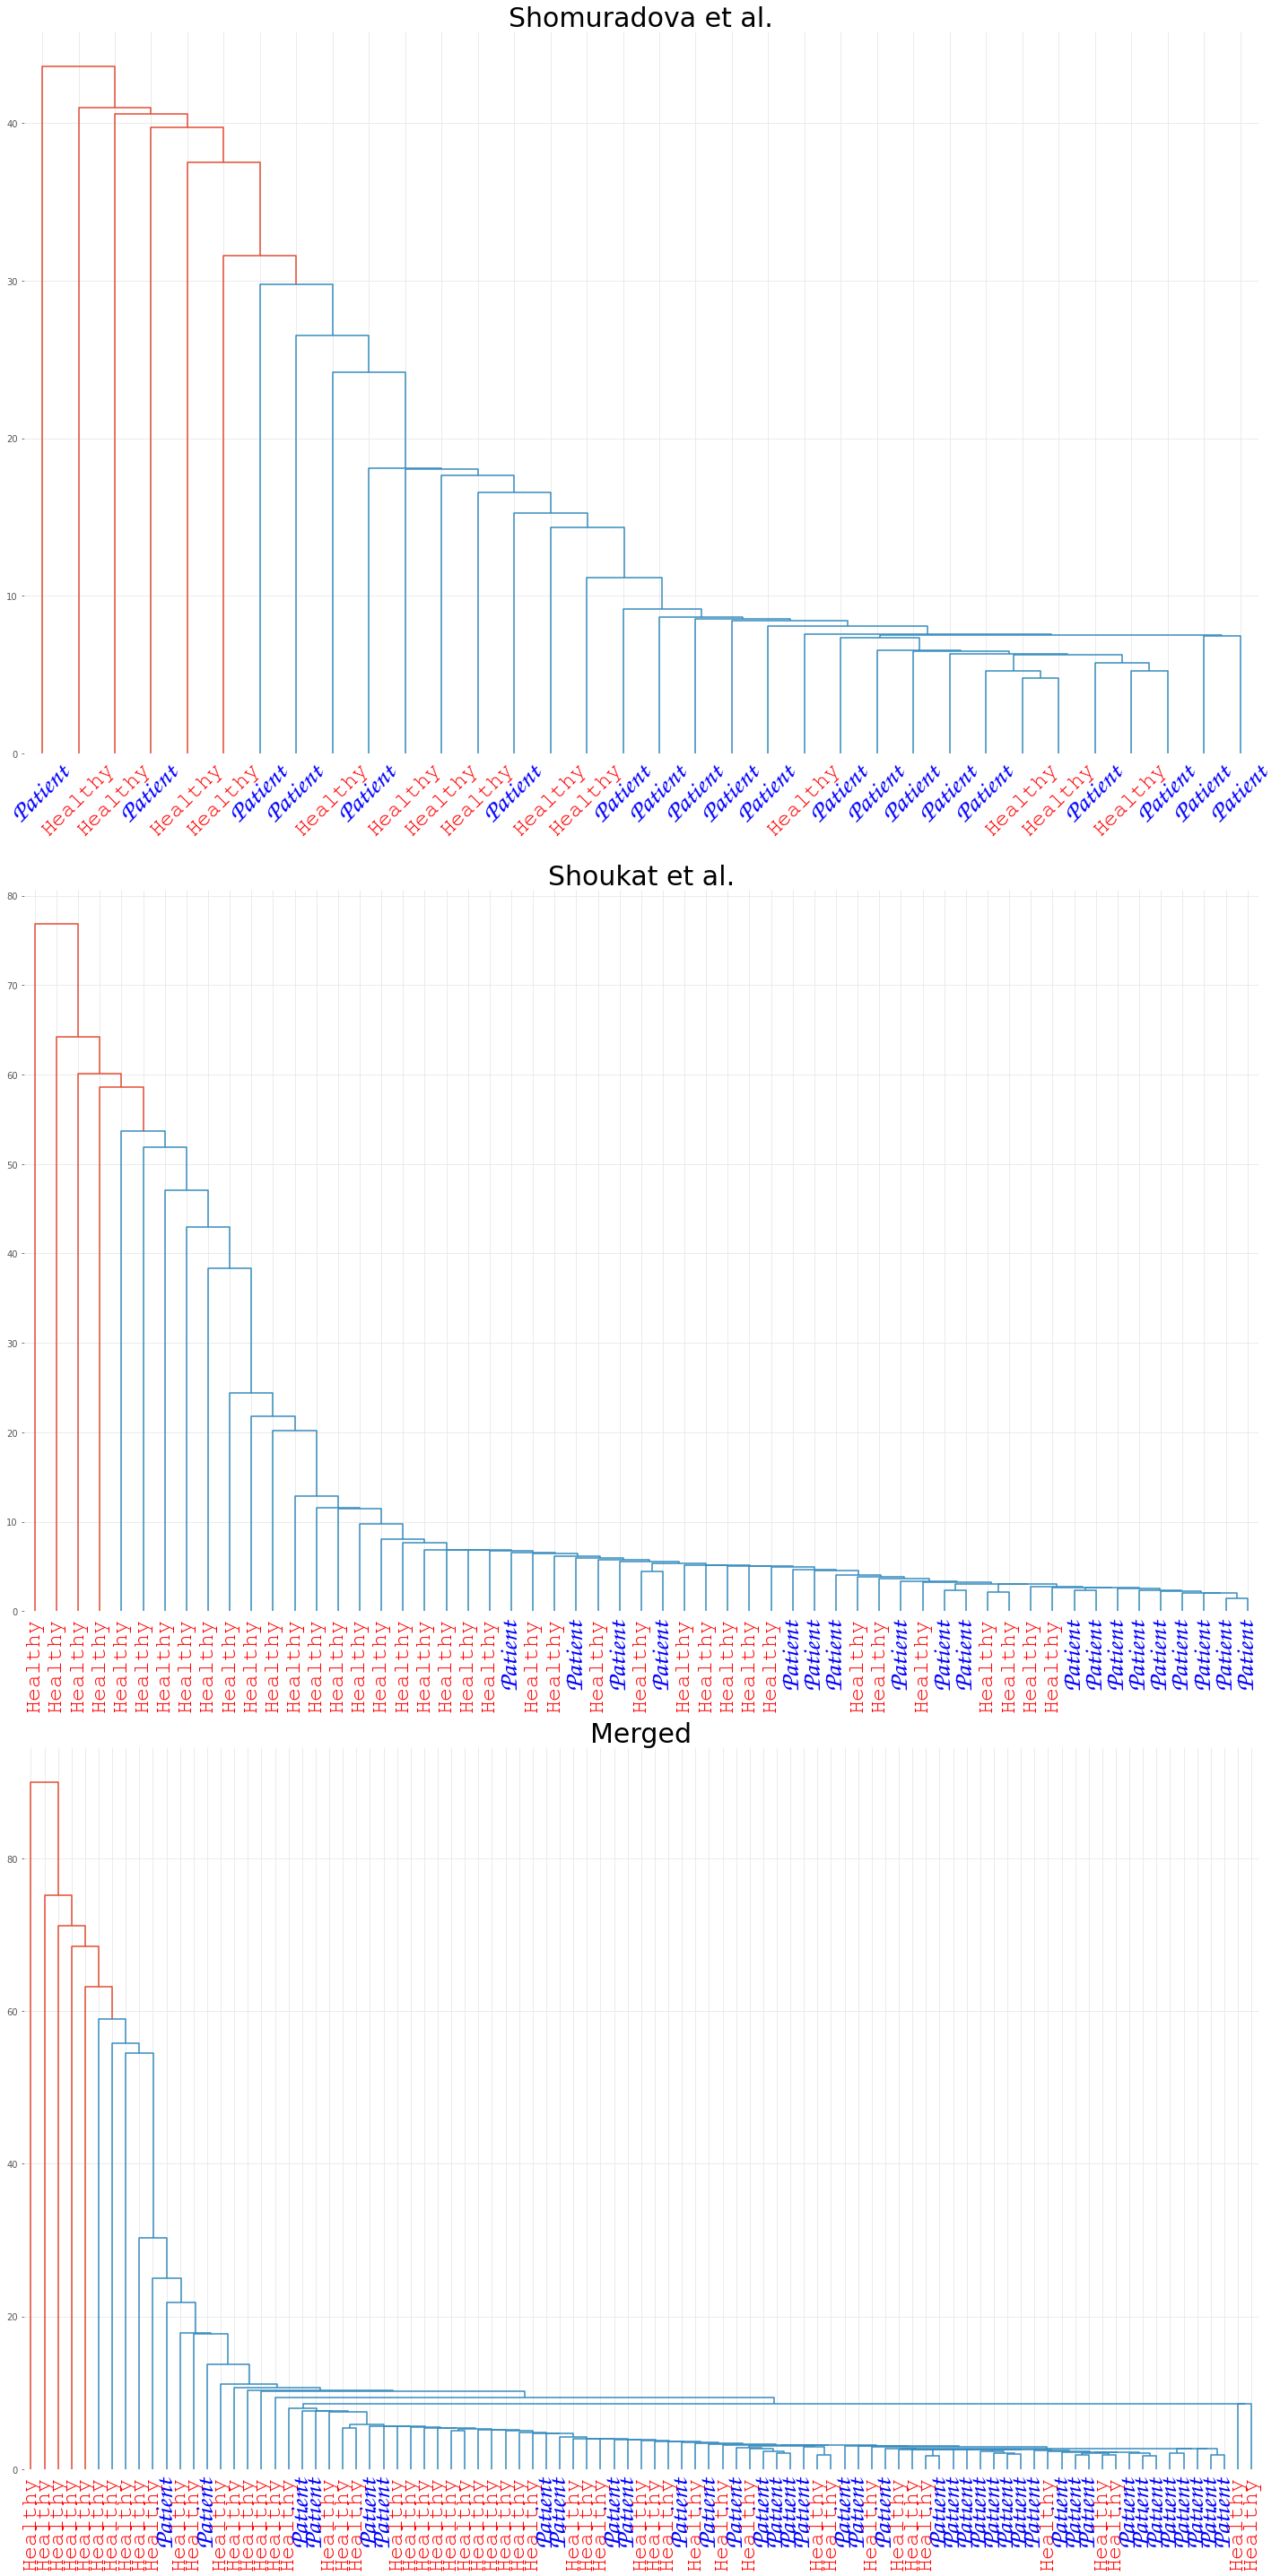

In [142]:
sc = StandardScaler()
ac = AgglomerativeClustering()
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 40))

def llf(k, true_labels):
    if true_labels[k] == 1:
        return 'Patient'
    return 'Healthy'

for i, title in zip(range(3), [OUR, PAPER, 'Merged']):
    if title == OUR:
        X_train, y_train = our_X.copy(), our_y.copy()
    elif title == PAPER:
        X_train, y_train = paper_X.copy(), paper_y.copy()
    else:
        X_train, y_train = X.copy(), y.copy()

    X_train = sc.fit_transform(X_train)
    
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    
    lnk = linkage(X_train,)
    
    axs[i].set_title(title, fontsize=30)
    _llf = partial(llf, true_labels=y_train)
    dendro = dendrogram(lnk, ax=axs[i], leaf_label_func=_llf,
                        leaf_font_size=20, show_leaf_counts=True, show_contracted=True, get_leaves=True)
    labels = axs[i].get_xmajorticklabels()
    for label in labels:
        if label.get_text() == 'Patient':
            label.set_color('blue')
            label.set_family('Z003')
            label.set_fontsize(30)
        else:
            label.set_color('red')
            label.set_family('Tlwg Typo')
            label.set_fontsize(25)
fig.tight_layout()
plt.savefig('cluster_by_label_only_kmers.png')

#####  Cluster by origin

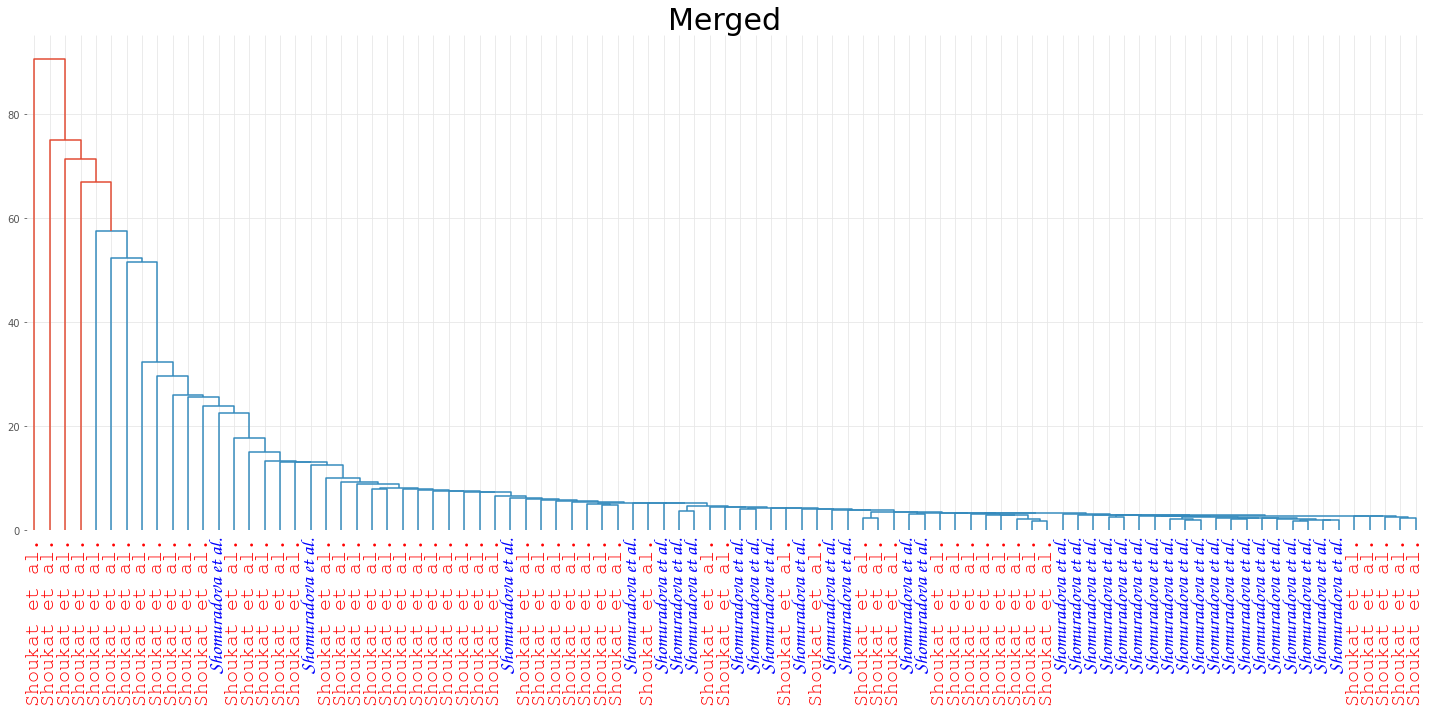

In [11]:
sc = StandardScaler()
ac = AgglomerativeClustering()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

def llf(k, true_labels):
    if true_labels[k] == 1:
        return OUR
    return PAPER

for i, title in zip(range(1), ['Merged']):
    if title == OUR:
        X_train, y_train = our_X.copy(), our_y.copy()
    elif title == PAPER:
        X_train, y_train = paper_X.copy(), paper_y.copy()
    else:
        X_train, y_train = X.copy(), y.copy()

    X_train = sc.fit_transform(X_train)
    
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    
    lnk = linkage(X_train,)
    
    true_labels = all_data['source_short'] == 'our'
    _llf = partial(llf, true_labels=true_labels)
    dendro = dendrogram(lnk, ax=axs, leaf_label_func=_llf,
                        leaf_font_size=20, show_leaf_counts=True, show_contracted=True, get_leaves=True)
    
    axs.set_title(title, fontsize=30)
    labels = axs.get_xmajorticklabels()
    for label in labels:
        if label.get_text() == OUR:
            label.set_color('blue')
            label.set_family('Z003')
            label.set_fontsize(20)
        else:
            label.set_color('red')
            label.set_family('Tlwg Typo')
            label.set_fontsize(20)
fig.tight_layout()
# plt.savefig('cluster_by_origin_only_kmers_not_normalized')
plt.savefig('cluster_by_origin_only_kmers')

## Statistically significant k-mers
First we will check if any k-mers statistically distinguish between groups in both datasets.

In [45]:
def find_ssk(df):
    """
    Find kmers with significantly different frequency between Healthy and Convalescent samples
    
    Returns dictionary with 2 lists containing significant kmers with Bonferroni 
    adjustment and when no adjustment is applied.
    
    If log(kmer frequency) passes normality test in both groups, performs the t-test for independent
    samples. Otherwise the Mann-Whitney rank test is performed.
    """
    total = 0
    results = []
    for kmer in tqdm(kmer_labels):
        tmp = df.loc[df[kmer] != 0, :]
        number_of_non_zero = tmp.shape[0]
        if number_of_non_zero > df.shape[0] * 0.6:
            total += 1

            healthy = np.log(tmp.query('label == 0')[kmer])
            conv = np.log(tmp.query('label == 1')[kmer])
            
            t1, p1 = sp.stats.shapiro(healthy)
            t2, p2 = sp.stats.shapiro(conv)

            if p1 > ALPHA and p2 > ALPHA:
                _, p = sp.stats.ttest_ind(healthy, conv)
            else:
                _, p = sp.stats.mannwhitneyu(healthy, conv)
            results.append([kmer, p])

    ssk_bonferroni = [] 
    ssk_noadj = []
    for i, (kmer, p) in enumerate(results):
        if p < ALPHA:
            ssk_noadj.append((kmer, p))
        if p < ALPHA / total:
            ssk_bonferroni.append((kmer, p))
    res = {
        'noadj': ssk_noadj,
        'bonf': ssk_bonferroni
    }
    return res

In [46]:
all_ssk = find_ssk(all_data)
our_ssk = find_ssk(our_data)
paper_ssk = find_ssk (paper_data)

100%|██████████| 2453/2453 [00:30<00:00, 79.22it/s] 


In [47]:
for ssk, title in zip((our_ssk, paper_ssk), (OUR, PAPER)):
    print('Number of significant k-mers in ' + title + " dataset")
    print('No adjustment:', len(ssk['noadj']), sep='\t')
    print('Bonferroni adjustment:', len(ssk['bonf']), sep='\t')
    print('=' * 10)
print(f"Number of mutual significant k-mers: {len(set(paper_ssk['noadj']).intersection(our_ssk['noadj']))}")

Number of significant k-mers in Shomuradova et al. dataset
No adjustment:	15
Bonferroni adjustment:	0
Number of significant k-mers in Shoukat et al. dataset
No adjustment:	48
Bonferroni adjustment:	7
Number of mutual significant k-mers: 0


No overlap between significant kmers! It might explain why CatBoost was not perfmorming greatly.

Next we will inspect the most significant k-mers in Shoukat et al. dataset.

In [53]:
best_kmers = sorted(paper_ssk['noadj'], key=lambda x: x[1])[:5]
best_kmers

[('GYT', 6.176231931323384e-07),
 ('YGY', 6.636082149053132e-07),
 ('YTF', 7.321672521713269e-07),
 ('QPQ', 1.1939521855337918e-05),
 ('PQH', 1.2350813622408369e-05)]

In [54]:
best_kmers = [('YTF', 3.8160612307013635e-07),
 ('GYT', 4.7079583126804254e-07),
 ('YGY', 3.023476330014292e-06),
 ('PQH', 1.945159429928686e-05),
 ('QHF', 1.9842761624294615e-05)]
best_kmers = [kmer[0] for kmer in best_kmers]

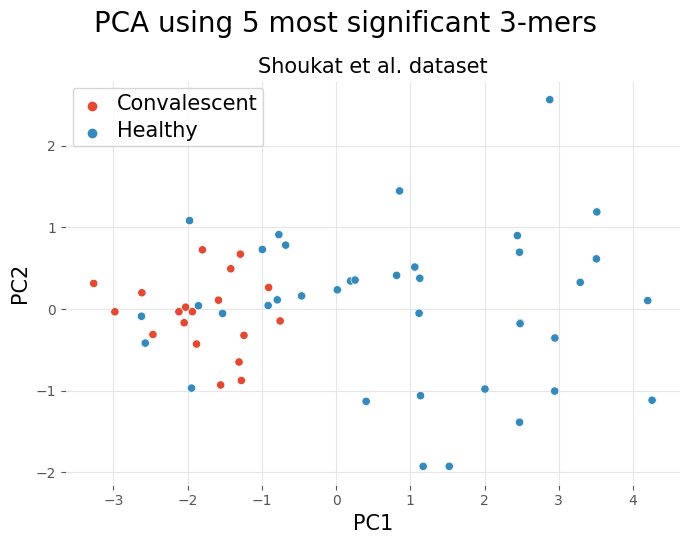

In [70]:
pca = PCA(n_components=2)
sc = StandardScaler()
X_paper_best = pca.fit_transform(sc.fit_transform(paper_data[best_kmers]))

fig, ax = plt.subplots(figsize=(7, 5.5), dpi=100)
ax = sns.scatterplot(x=X_paper_best[:, 0], y=X_paper_best[:, 1], hue=np.where(paper_data['label'], 'Convalescent', 'Healthy'),
                   hue_order=['Convalescent', 'Healthy'])

ax_label_fontsize=15
ax.set_xlabel('PC1', fontsize=ax_label_fontsize)
ax.set_ylabel('PC2', fontsize=ax_label_fontsize)

fig.suptitle('PCA using 5 most significant 3-mers', fontsize=20)
ax.set_title('Shoukat et al. dataset', fontsize=15)

for text in ax.get_legend().texts:
    text.set_fontsize(15)
fig.tight_layout()
plt.savefig('ssk_pca_Shoukat')

Classes are easily separetable when using only these k-mers. 

Now we will inspect location and possibly origin of these kmers.

In [79]:
# folder = 'use_of_ml_paper_data/healthy/'
folder = 'use_of_ml_paper_data/patient/'

positions = {}
freqs = []
for k in best_kmers:
    positions[k] = [0] * 100

for filename in tqdm(os.listdir(folder)):
    df = rename_table_fields(pd.read_csv(folder + filename, sep='\t'))
    # df = normalize_v_usage(df)
    for i, row in df.iterrows():
        seq = row['aaSeqCDR3']
    
        for kmer in best_kmers:
            index = seq.find(kmer)
            if index >= 0:
                try:
                    positions[kmer][len(seq) - index - 3] += row['freq']
                except IndexError:
                    print(len(seq) - index)

 32%|███▏      | 6/19 [00:08<00:17,  1.34s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
 47%|████▋     | 9/19 [00:13<00:13,  1.35s/it]/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 19/19 [00:25<00:00,  1.35s/it]


<ipython-input-84-a0a4a803dbad>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(values, 'ro', color=c, label=k)


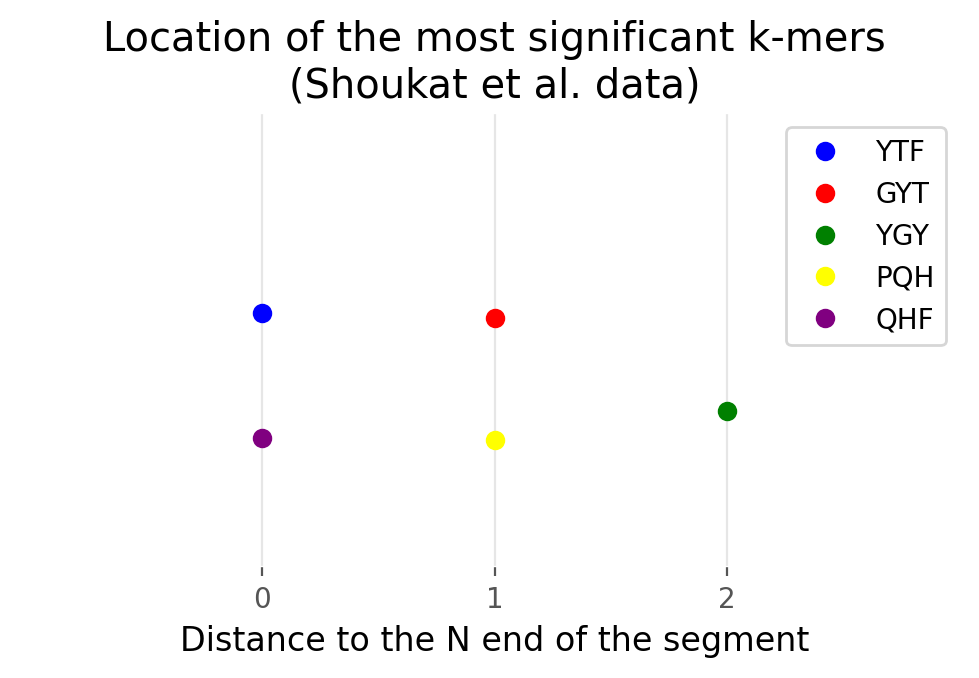

In [84]:
title = f'Location of the most significant k-mers\n({PAPER} data)'

plt.figure(figsize=(6, 3), dpi=200)
colors = ['blue', 'red', 'green', 'yellow', 'purple']
for c, (k, values) in zip(colors, positions.items()):
    plt.plot(values, 'ro', color=c, label=k)
    
plt.legend()
plt.xlabel('Distance to the N end of the segment')
plt.title(title)
plt.xticks([0, 1, 2])
plt.yticks([0])
plt.xlim(-1, 3)
plt.ylim(0.1, 2);
plt.savefig('ssk_location')

The 5 most significant k-mers are located at the end of the sequence meaning _they come from the J segment_.

We'll make another visualization: SequenceLogo for CDR3 tail to see how noticable the difference in end of the sequence is.

/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/iam28th/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


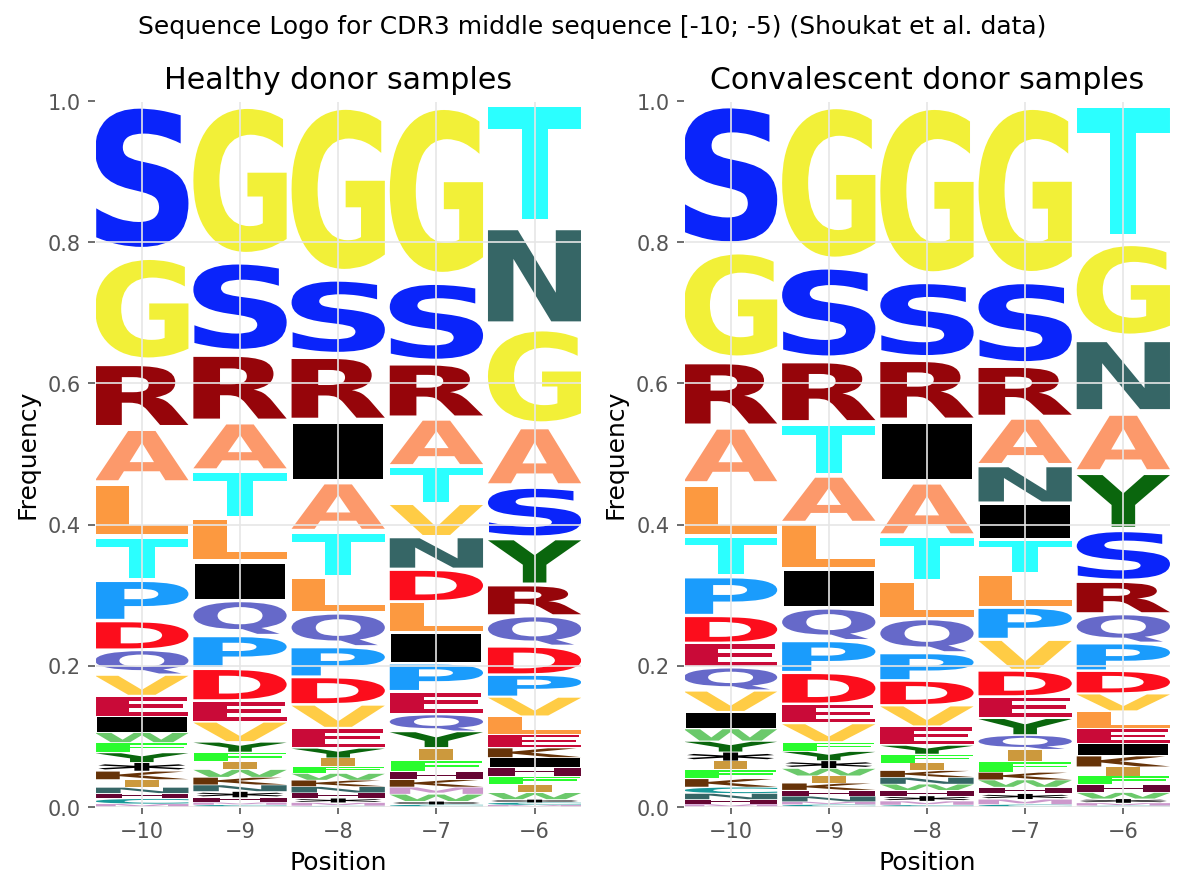

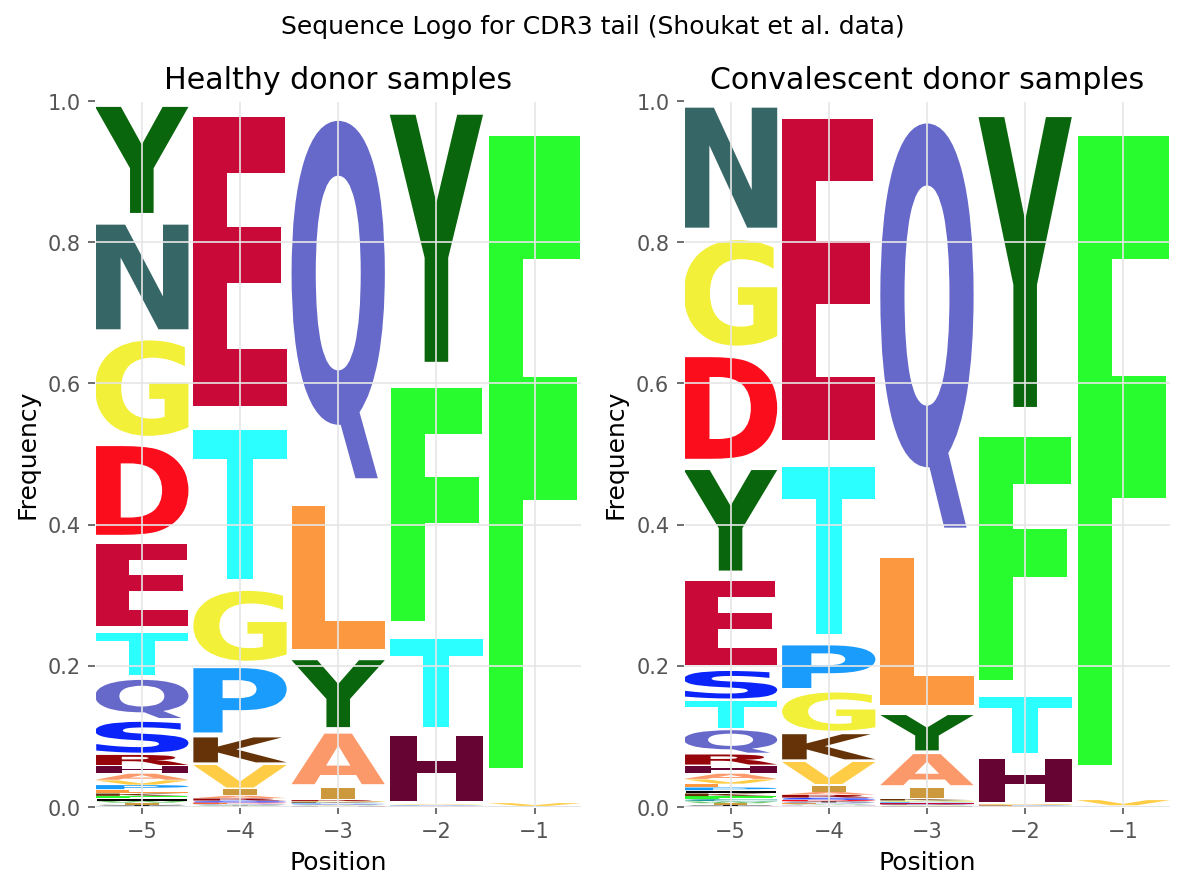

In [95]:
def aa_freqs(folder, start=-5):
    res = {
        i: defaultdict(int) for i in range(start, start+5) 
    }
    for filename in os.listdir(folder):
        df = rename_table_fields(pd.read_csv(folder + filename, sep='\t'))
        df = normalize_v_usage(df)
        for i, row in df.iterrows():
            seq = row['aaSeqCDR3']
            for i in range(start, start+5):
                try:
                    res[i][seq[i]] += row['freq']
                except IndexError:
                    pass
                
    res = pd.DataFrame(res).fillna(0).transpose()
    res = res.div(res.sum(axis=1), axis=0)   
    return res # pd.DataFrame(res).fillna(0).transpose()

folder_healthy = 'use_of_ml_paper_data/healthy/'
folder_conv = 'use_of_ml_paper_data/patient/'
   
healthy_mid = aa_freqs(folder_healthy, start=-10)
conv_mid = aa_freqs(folder_conv, start=-10)

healthy_tail = aa_freqs(folder_healthy)
conv_tail = aa_freqs(folder_conv)
    
    
fig_mid, axs_mid = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(8, 6))
fig_tail, axs_tail = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(8, 6))


logo_h_mid = logomaker.Logo(healthy_mid, color_scheme='skylign_protein',
              vpad=0.1, ax=axs_mid[0])
logo_c_mid = logomaker.Logo(conv_mid, color_scheme='skylign_protein',
              vpad=0.1, ax=axs_mid[1])
logo_h_tail = logomaker.Logo(healthy_tail, color_scheme='skylign_protein',
              vpad=0.1, ax=axs_tail[0])
logo_c_tail = logomaker.Logo(conv_tail, color_scheme='skylign_protein',
              vpad=0.1, ax=axs_tail[1])

for axs in (axs_mid, axs_tail):
    for ax in axs.reshape(-1):
        ax.set_xlabel('Position')
        ax.set_ylabel('Frequency')
    axs[0].set_title('Healthy donor samples');
    axs[1].set_title('Convalescent donor samples')

title_tail = f'Sequence Logo for CDR3 tail ({PAPER} data)'
title_mid = f'Sequence Logo for CDR3 middle sequence [-10; -5) ({PAPER} data)'
for fig, title in zip((fig_mid, fig_tail), (title_mid, title_tail)):
    fig.suptitle(title)
    fig.tight_layout()

## Statistically significant J-segments

Now that we know that the most significant k-mers come from the J-segment, we will identify the most significant J-segments and compare them with results from literature.

In [99]:
def find_ssj(df):
    """
    Find J-segments with significantly different frequency between Healthy and Convalescent samples
    
    Returns dictionary with 2 lists containing significant J-segments with Bonferroni 
    adjustment and when no adjustment is applied.
    
    If log(segment frequency) passes normality test in both groups, performs the t-test for independent
    samples. Otherwise the Mann-Whitney rank test is performed.
    """ 
    total = 0
    results = []
    for segment in tqdm(j_segment_labels):
        tmp = df.loc[df[segment] != 0, :]
        number_of_non_zero = tmp.shape[0]
        if number_of_non_zero > 30:
            total += 1

            healthy = np.log(tmp.query('label == 0')[segment])
            conv = np.log(tmp.query('label == 1')[segment])

            t1, p1 = sp.stats.shapiro(healthy)
            t2, p2 = sp.stats.shapiro(conv)
            if p1 > 0.05 and p2 > 0.05:
                _, p = sp.stats.ttest_ind(healthy, conv)
            else:
                _, p = sp.stats.kruskal(healthy, conv)
            results.append([segment, p])

    ssj_bonferroni = [] 
    ssj_noadj = []
    for i, (segment, p) in enumerate(results):
        if p < ALPHA:
            ssj_noadj.append((segment, p))
        if p < ALPHA / total:
            ssj_bonferroni.append((segment, p))
    res = {
        'noadj': ssj_noadj,
        'bonf': ssj_bonferroni
    }
    return res

100%|██████████| 13/13 [00:02<00:00,  6.22it/s]


In [101]:
paper_j = find_ssj(paper_data)
our_j = find_ssj(our_data)

100%|██████████| 13/13 [00:02<00:00,  6.08it/s]


In [102]:
paper_j

{'noadj': [('TRBJ2-7', 0.002574786838243328),
  ('TRBJ2-1', 0.005499714776195487),
  ('TRBJ1-1', 0.00521998553543395),
  ('TRBJ1-6', 0.040932087978270866),
  ('TRBJ1-5', 1.1621350874987664e-05),
  ('TRBJ1-2', 1.5276958078391913e-06),
  ('TRBJ2-3', 0.002712540127777168)],
 'bonf': [('TRBJ2-7', 0.002574786838243328),
  ('TRBJ1-5', 1.1621350874987664e-05),
  ('TRBJ1-2', 1.5276958078391913e-06),
  ('TRBJ2-3', 0.002712540127777168)]}

In [article 1](https://www.sciencedirect.com/science/article/pii/S0888754320320838) was found that TRBJ2-6  and TRBJ2-7 were significantly higher in COVID-19 patients; with TRBJ2-6 that is not the case in Shoukat et al. dataset. It might happen as a result of systematic errors (as discussed 
[here](https://www.nature.com/articles/s41587-020-0656-3)) or because of individual repertoire diversity.

In [103]:
our_j  # no significantly different J segments in Shomuradova et al. dataset

{'noadj': [], 'bonf': []}